## Understanding Data Preparation for Time Series Analysis

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from scalecast.Forecaster import lags, rolling_mean, rolling_std, diff, seasonality
from darts import TimeSeries
from darts.models import Prophet
from pmdarima import auto_arima

In [5]:
!pip install --upgrade tsfresh

     ---------------------------------------- 98.2/98.2 kB 2.8 MB/s eta 0:00:00


     -------------------------------------- 136.2/136.2 kB 7.9 MB/s eta 0:00:00


In [7]:
import tsfresh

In [204]:
from tsfresh import extract_features

In [3]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from pmdarima.arima.utils import ndiffs
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sktime.transformations.panel.interpolate import TSInterpolator        # >> Interpolator
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor   # >> Feature Extractor
from sktime.transformations.series.summarize import SummaryTransformer  # >> Explore
from sktime.transformations.base import BaseTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from tsfresh import extract_features
from scipy import signal
from sktime.transformations.series.detrend import Deseasonalizer
from statsmodels.tsa.holtwinters import ExponentialSmoothing


class TimeSeriesFeatureEngineering:
    
    def __init__(self, data):
        self.data = data
    
    def create_darts_features(self):
        series = TimeSeries.from_dataframe(self.data)
        scaler = Scaler()
        self.data = scaler.fit_transform(series)
        return self.data
    
    def create_pmdarima_features(self):
        d = ndiffs(self.data)
        self.data = pd.DataFrame({'y': self.data})
        self.data['diff_y'] = self.data['y'].diff().fillna(0)
        for i in range(1, d+1):
            self.data[f'diff_y_{i}'] = self.data['diff_y'].diff(periods=i).fillna(0)
        return self.data
    
    def add_lags(self,column_id, lags):
        """
        Add lagged variables to the time series data.
        """
        for lag in lags:
            self.data[f"lag_{lag}"] = self.data[column_id].shift(lag)
        return self.data.fillna(0)
    
    def add_rolling_statistics(self,column_id, window):
        """
        Add rolling statistics to the time series data.
        """
        self.data[f"rolling_mean_{window}"] = self.data[column_id].rolling(window=window).mean()
        self.data[f"rolling_std_{window}"] = self.data[column_id].rolling(window=window).std()
        return self.data.fillna(0)
        
    def add_expanding_statistics(self,column_id):
        """
        Add expanding statistics to the time series data.
        """
        self.data["expanding_mean"] = self.data[column_id].expanding().mean()
        self.data["expanding_std"] = self.data[column_id].expanding().std()
        return self.data.fillna(0)
        
    def add_seasonality(self, period):
        """
        Add seasonality indicators to the time series data.
        """
        self.data["seasonality"] = self.data.index % period
        return self.data.fillna(0)
        
    def add_tsfresh_features(self, column_id):
        """
        Add features generated by tsfresh to the time series data.
        """
        extracted_features = extract_features(self.data.reset_index(), column_id=column_id)
        extracted_features = extracted_features.loc[:, extracted_features.apply(pd.Series.nunique) != 1]
        extracted_features.columns = [f"tsfresh_{col}" for col in extracted_features.columns]
        self.data = self.data.merge(extracted_features, left_index=True, right_index=True, how="outer")
        return self.data
    
    def create_rolling_statistics(self, windows):
        for i in windows:
            self.data[f'rolling_mean_{i}'] = self.data.iloc[:,0].rolling(window=i).mean()
            self.data[f'rolling_std_{i}'] = self.data.iloc[:,0].rolling(window=i).std()
            self.data[f'rolling_min_{i}'] = self.data.iloc[:,0].rolling(window=i).min()
            self.data[f'rolling_max_{i}'] = self.data.iloc[:,0].rolling(window=i).max()
            self.data[f'rolling_sum_{i}'] = self.data.iloc[:,0].rolling(window=i).sum()
        return self.data.fillna(0)
    
    def fill_missing_values(self):
        
        """
        Fill missing values in the time series data using the specified method.
        """
        series = TimeSeries.from_dataframe(self.data)
        filler = MissingValuesFiller()
        filled = filler.transform(series)
        return filled
    
    def apply_detrending(self,col):
        '''
        This function helps in detrending the time series using scipy's signal module
        
        '''
        result = signal.detrend(self.data[col])
        plt.title('Detrended Series', fontsize=14)
        plt.xlabel('length')
        plt.ylabel('value')
        plt.plot(result)
        return result
    
    def deseasonalize_data(self, period):
        """
        Remove the seasonal component from the time series data using the Deseasonalizer transformer from sktime.
        """
        transformer = Deseasonalizer(sp=period)
        result = transformer.fit_transform(self.data)
        plt.title('DeSeasonalised Series', fontsize=14)
        plt.xlabel('length')
        plt.ylabel('value')
        plt.plot(result)
        return result
    
#     def convert_to_series(self):
#         """
#         Convert tabular data to a time series using the TabularToSeriesAdaptor transformer from sktime.
#         """
#         transformer = TabularToSeriesAdaptor(BaseTransformer)
#         self.data = transformer.fit_transform(self.data)
#         return self.data
    
    def summarize_data(self):
        """
        Summarize the time series data using the SummaryTransformer transformer from sktime.
        """
        transformer = SummaryTransformer()
        self.data = transformer.fit_transform(self.data)
        return self.data
    
    def fourier_transform(self):
        """
        Compute the Fourier Transform of the time series data.
        
        Returns:
        - magnitudes: numpy array containing the magnitudes of the Fourier Transform.
        - frequencies: numpy array containing the frequencies corresponding to the magnitudes.
        
        Note that the Fourier Transform assumes that the time series is stationary (i.e., its statistical properties do 
        not change over time), so it may be necessary to perform preprocessing (e.g., detrending, deseasonalizing) 
        before applying the transform.
                
        """
        
        # Compute the Fourier Transform of the time series
        fourier_transform = np.fft.fft(self.data)
        
        # Compute the magnitudes of the Fourier Transform
        magnitudes = np.abs(fourier_transform)
        
        # Compute the frequencies corresponding to the magnitudes
        n = len(self.data)
        timestep = 1  # assuming a unit time step
        frequencies = np.fft.fftfreq(n, d=timestep)
        
        # Return the magnitudes and frequencies
        return magnitudes, frequencies
    
    def exp_smoothing(self, trend=None, damped_trend=False, seasonal=None,seasonal_periods=None, initialization_method='estimated', use_boxcox=False):
        '''
        Exponential smoothing is an advanced smoothing technique that takes into account the trend and seasonality 
        in the data. It assigns exponentially decreasing weights to the historical data points with the most recent
        data points having the highest weight.
        
        Parameters:
        
        initialization_method : {estimated,heuristic,legacy-heuristic,Known}
        trend : {“add”, “mul”, “additive”, “multiplicative”, None}
        damped_trend : bool
        seasonal : {“add”, “mul”, “additive”, “multiplicative”, None}
        seasonal_periods : int
        use_boxcox : {True, False, ‘log’, float}
        
        '''
        
        transformer = ExponentialSmoothing(self.data,trend=trend, damped_trend=damped_trend, seasonal=seasonal,seasonal_periods=seasonal_periods, initialization_method=initialization_method, use_boxcox=use_boxcox,)
        result = transformer.fit()
        smoothed_data = result.fittedvalues.tolist()
        return smoothed_data
    
    def log_transform(self):
        """
        Applies the natural logarithm transformation to the time series data.
        """
        return np.log(self.data)
    
    def apply_boxcox_transformation(self,col):
        """
        Applies the Box-Cox transformation to the time series data.
        """
        transformed_data, lambda_ = boxcox(self.data[col])
        return transformed_data, lambda_
    
    def normalize_data(self):
        '''
        Normalize the time series using MinMaxScaler
        '''
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(self.data)
        return normalized_data
    
    def standardize_data(self):
        '''
        Standardize the time series using StandardScaler
        '''
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(self.data)
        return standardized_data
            


In [203]:
from sktime.transformations.base import BaseTransformer

In [98]:
df = pd.read_csv('a10.csv', parse_dates=['date']) #  , index_col='date')

In [99]:
test1 = TimeSeriesFeatureEngineering(df.value)

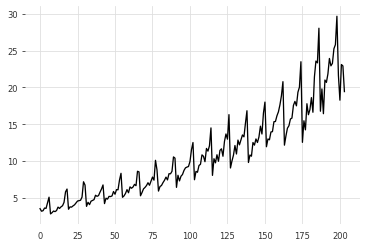

In [100]:
plt.plot(df.value)

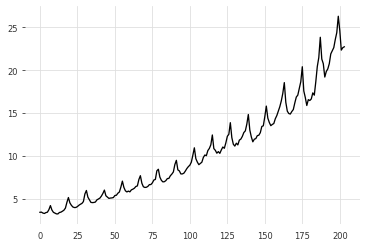

In [110]:
plt.plot(test1.exp_smoothing(seasonal_periods=12))

<Axes: xlabel='date'>

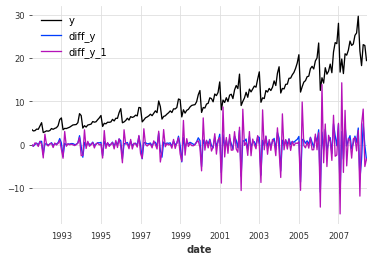

In [200]:
val1 = test1.create_pmdarima_features()
val1.plot()

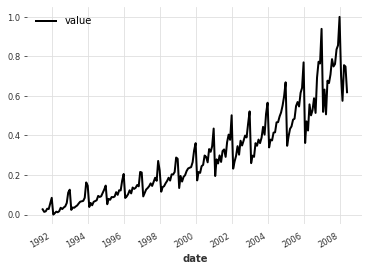

In [201]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
test1 = TimeSeriesFeatureEngineering(df)

val2 = test1.create_darts_features()

val2.plot()

In [257]:
test1 = TimeSeriesFeatureEngineering(df)

In [239]:
test1.add_expanding_statistics('value')

,date,value,expanding_mean,expanding_std
0,1991-07-01,3.526591,3.526591,0.000000
1,1991-08-01,3.180891,3.353741,0.244447
2,1991-09-01,3.252221,3.319901,0.182517
3,1991-10-01,3.611003,3.392676,0.208311
4,1991-11-01,3.565869,3.427315,0.196327
...,...,...,...,...
199,2008-02-01,21.654285,10.489734,5.827598
200,2008-03-01,18.264945,10.528416,5.838823
201,2008-04-01,23.107677,10.590690,5.891146
202,2008-05-01,22.912510,10.651389,5.939841


In [240]:
test1.add_lags('value',[1, 2, 3])

,date,value,expanding_mean,expanding_std,lag_1,lag_2,lag_3
0,1991-07-01,3.526591,3.526591,0.000000,0.000000,0.000000,0.000000
1,1991-08-01,3.180891,3.353741,0.244447,3.526591,0.000000,0.000000
2,1991-09-01,3.252221,3.319901,0.182517,3.180891,3.526591,0.000000
3,1991-10-01,3.611003,3.392676,0.208311,3.252221,3.180891,3.526591
4,1991-11-01,3.565869,3.427315,0.196327,3.611003,3.252221,3.180891
...,...,...,...,...,...,...,...
199,2008-02-01,21.654285,10.489734,5.827598,29.665356,25.806090,25.250030
200,2008-03-01,18.264945,10.528416,5.838823,21.654285,29.665356,25.806090
201,2008-04-01,23.107677,10.590690,5.891146,18.264945,21.654285,29.665356
202,2008-05-01,22.912510,10.651389,5.939841,23.107677,18.264945,21.654285


In [241]:
test1.add_rolling_statistics('value',3)

,date,value,expanding_mean,expanding_std,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3
0,1991-07-01,3.526591,3.526591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1991-08-01,3.180891,3.353741,0.244447,3.526591,0.000000,0.000000,0.000000,0.000000
2,1991-09-01,3.252221,3.319901,0.182517,3.180891,3.526591,0.000000,3.319901,0.182517
3,1991-10-01,3.611003,3.392676,0.208311,3.252221,3.180891,3.526591,3.348038,0.230510
4,1991-11-01,3.565869,3.427315,0.196327,3.611003,3.252221,3.180891,3.476364,0.195421
...,...,...,...,...,...,...,...,...,...
199,2008-02-01,21.654285,10.489734,5.827598,29.665356,25.806090,25.250030,25.708577,4.006426
200,2008-03-01,18.264945,10.528416,5.838823,21.654285,29.665356,25.806090,23.194862,5.854261
201,2008-04-01,23.107677,10.590690,5.891146,18.264945,21.654285,29.665356,21.008969,2.485023
202,2008-05-01,22.912510,10.651389,5.939841,23.107677,18.264945,21.654285,21.428377,2.741350


In [245]:
test1.add_seasonality(6)

,date,value,expanding_mean,expanding_std,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,seasonality
0,1991-07-01,3.526591,3.526591,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1991-08-01,3.180891,3.353741,0.244447,3.526591,NaN,NaN,NaN,NaN,1
2,1991-09-01,3.252221,3.319901,0.182517,3.180891,3.526591,NaN,3.319901,0.182517,2
3,1991-10-01,3.611003,3.392676,0.208311,3.252221,3.180891,3.526591,3.348038,0.230510,3
4,1991-11-01,3.565869,3.427315,0.196327,3.611003,3.252221,3.180891,3.476364,0.195421,4
...,...,...,...,...,...,...,...,...,...,...
199,2008-02-01,21.654285,10.489734,5.827598,29.665356,25.806090,25.250030,25.708577,4.006426,1
200,2008-03-01,18.264945,10.528416,5.838823,21.654285,29.665356,25.806090,23.194862,5.854261,2
201,2008-04-01,23.107677,10.590690,5.891146,18.264945,21.654285,29.665356,21.008969,2.485023,3
202,2008-05-01,22.912510,10.651389,5.939841,23.107677,18.264945,21.654285,21.428377,2.741350,4


In [264]:
df.isna().sum()

date     0
value    0
dtype: int64

In [278]:
df = pd.read_csv('a10.csv', parse_dates=['date'])
test1 = TimeSeriesFeatureEngineering(df)

test1.add_tsfresh_features('date')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]


,date,value,tsfresh_value__sum_values,tsfresh_value__abs_energy,tsfresh_value__mean_abs_change,tsfresh_value__mean_change,tsfresh_value__mean_second_derivative_central,tsfresh_value__median,tsfresh_value__mean,tsfresh_value__skewness,...,tsfresh_index__fourier_entropy__bins_5,tsfresh_index__fourier_entropy__bins_10,tsfresh_index__fourier_entropy__bins_100,tsfresh_index__permutation_entropy__dimension_3__tau_1,tsfresh_index__permutation_entropy__dimension_4__tau_1,tsfresh_index__permutation_entropy__dimension_5__tau_1,tsfresh_index__permutation_entropy__dimension_6__tau_1,tsfresh_index__permutation_entropy__dimension_7__tau_1,tsfresh_index__query_similarity_count__query_None__threshold_0.0,tsfresh_index__mean_n_absolute_max__number_of_maxima_7
1991-07-01 00:00:00,NaT,NaN,3.526591,12.436844,NaN,NaN,NaN,3.526591,3.526591,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-01 00:00:00,NaT,NaN,3.180891,10.118068,NaN,NaN,NaN,3.180891,3.180891,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-09-01 00:00:00,NaT,NaN,3.252221,10.576941,NaN,NaN,NaN,3.252221,3.252221,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-10-01 00:00:00,NaT,NaN,3.611003,13.039343,NaN,NaN,NaN,3.611003,3.611003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-11-01 00:00:00,NaT,NaN,3.565869,12.715422,NaN,NaN,NaN,3.565869,3.565869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2008-02-01,21.654285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,2008-03-01,18.264945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,2008-04-01,23.107677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,2008-05-01,22.912510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [296]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
test1 = TimeSeriesFeatureEngineering(df)

test1.create_rolling_statistics([2,3,4])


,value,rolling_mean_2,rolling_std_2,rolling_min_2,rolling_max_2,rolling_sum_2,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_sum_3,rolling_mean_4,rolling_std_4,rolling_min_4,rolling_max_4,rolling_sum_4
date,,,,,,,,,,,,,,,,
1991-07-01,3.526591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-08-01,3.180891,3.353741,0.244447,3.180891,3.526591,6.707482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-09-01,3.252221,3.216556,0.050438,3.180891,3.252221,6.433112,3.319901,0.182517,3.180891,3.526591,9.959703,0.000000,0.000000,0.000000,0.000000,0.000000
1991-10-01,3.611003,3.431612,0.253697,3.252221,3.611003,6.863224,3.348038,0.230510,3.180891,3.611003,10.044115,3.392676,0.208311,3.180891,3.611003,13.570706
1991-11-01,3.565869,3.588436,0.031915,3.565869,3.611003,7.176872,3.476364,0.195421,3.252221,3.611003,10.429093,3.402496,0.217453,3.180891,3.611003,13.609984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-01,21.654285,25.659821,5.664683,21.654285,29.665356,51.319641,25.708577,4.006426,21.654285,29.665356,77.125731,25.593940,3.279258,21.654285,29.665356,102.375761
2008-03-01,18.264945,19.959615,2.396625,18.264945,21.654285,39.919230,23.194862,5.854261,18.264945,29.665356,69.584586,23.847669,4.955086,18.264945,29.665356,95.390676
2008-04-01,23.107677,20.686311,3.424329,18.264945,23.107677,41.372622,21.008969,2.485023,18.264945,23.107677,63.026907,23.173066,4.780183,18.264945,29.665356,92.692263


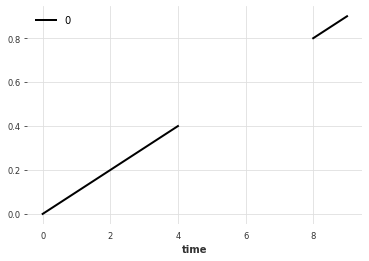

In [320]:
values = np.arange(start=0, stop=1, step=0.1)
values[5:8] = np.nan
series = TimeSeries.from_values(values)

series.plot()
# transformer = MissingValuesFiller()
# series_filled = transformer.transform(series)
# print(series_filled)

In [328]:
df

,value,rolling_mean_2,rolling_std_2,rolling_min_2,rolling_max_2,rolling_sum_2,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_sum_3,rolling_mean_4,rolling_std_4,rolling_min_4,rolling_max_4,rolling_sum_4
date,,,,,,,,,,,,,,,,
1991-07-01,3.526591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-01,3.180891,3.353741,0.244447,3.180891,3.526591,6.707482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-09-01,3.252221,3.216556,0.050438,3.180891,3.252221,6.433112,3.319901,0.182517,3.180891,3.526591,9.959703,NaN,NaN,NaN,NaN,NaN
1991-10-01,3.611003,3.431612,0.253697,3.252221,3.611003,6.863224,3.348038,0.230510,3.180891,3.611003,10.044115,3.392676,0.208311,3.180891,3.611003,13.570706
1991-11-01,3.565869,3.588436,0.031915,3.565869,3.611003,7.176872,3.476364,0.195421,3.252221,3.611003,10.429093,3.402496,0.217453,3.180891,3.611003,13.609984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-01,21.654285,25.659821,5.664683,21.654285,29.665356,51.319641,25.708577,4.006426,21.654285,29.665356,77.125731,25.593940,3.279258,21.654285,29.665356,102.375761
2008-03-01,18.264945,19.959615,2.396625,18.264945,21.654285,39.919230,23.194862,5.854261,18.264945,29.665356,69.584586,23.847669,4.955086,18.264945,29.665356,95.390676
2008-04-01,23.107677,20.686311,3.424329,18.264945,23.107677,41.372622,21.008969,2.485023,18.264945,23.107677,63.026907,23.173066,4.780183,18.264945,29.665356,92.692263


In [332]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
fill_missing = TimeSeriesFeatureEngineering(df)

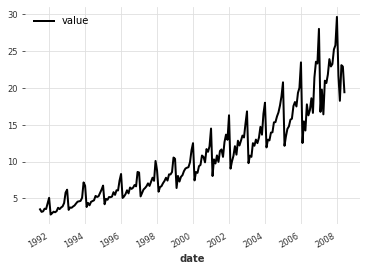

In [333]:
fill_missing.fill_missing_values().plot()

In [23]:
#from scalecast.features import add_lags, add_rolling_stats
#from scalecast.transformations import TimeSeriesInterpolation, TimeSeriesResampler, TimeSeriesScaler

In [8]:
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

In [17]:
df

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


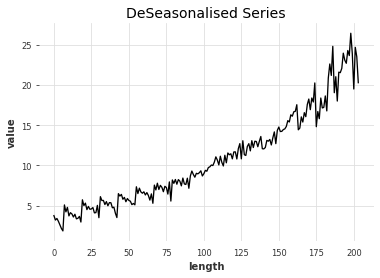

In [59]:
x = test1.deseasonalize_data(12)

In [60]:
x

0       3.754400
1       3.204007
2       3.401243
3       3.041842
4       2.599033
         ...    
199    23.926285
200    19.498771
201    24.679141
202    23.505708
203    20.282604
Name: value, Length: 204, dtype: float64

In [38]:
def convert_to_series(df):
        """
        Convert tabular data to a time series using the TabularToSeriesAdaptor transformer from sktime.
        """
        transformer = TabularToSeriesAdaptor(BaseTransformer)
        df_new = transformer.fit_transform(df)
        return df_new

In [112]:
#convert_to_series(df)

In [46]:
df

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [40]:
test1.summarize_data()

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,10.69443,5.956998,2.81452,29.665356,4.117559,5.844095,9.319345,14.289964,19.406398


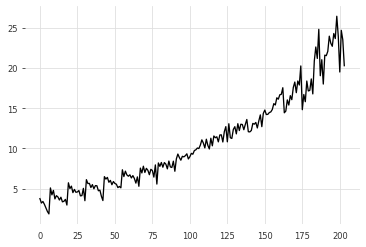

In [66]:
plt.plot(x)

In [63]:
x1 = TimeSeriesFeatureEngineering(x)

mag,frq = x1.fourier_transform()

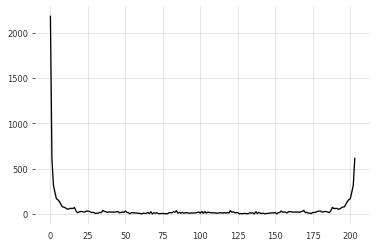

In [64]:
plt.plot(mag)

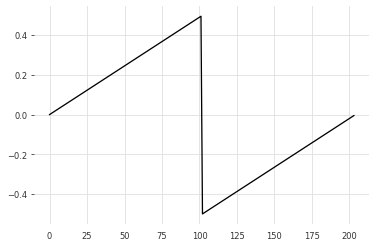

In [67]:
plt.plot(frq)

In [119]:
from scalecast._utils import _developer_utils
from scalecast._Forecaster_parent import ForecastError
from scalecast.Forecaster import Forecaster
import pandas as pd
import numpy as np
import warnings
import logging

class SeriesTransformer:
    def __init__(self, f, deepcopy=True):
        """ Initiates the object.
        Args:
            f (Forecaster): The Forecaster object that will receive each transformation/revert.
            deepcopy (bool): Default True. Whether to store a deepcopy of the Forecaster object in the SeriesTransformer object.
        """
        self.f = f.__deepcopy__() if deepcopy else f

    def __repr__(self):
        return "SeriesTransformer(\n{}\n)".format(self.f)

    def __str__(self):
        return self.__repr__()

    def Transform(self, transform_func, **kwargs):
        """ Transforms the y attribute in the Forecaster object.
        
        Args:
            transform_func (function): The function that will be used to make the transformation.
                If using a user function, first argument must be the array to transform.
            **kwargs: Passed to the function passed to transform_func.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> import math
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> def log10(x):
        >>>     return [math.log(i,base=10) for i in x]
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.Transform(log10)
        """
        self.f.y = pd.Series(transform_func(self.f.y, **kwargs))
        self.f.levely = list(transform_func(self.f.levely, **kwargs))
        return self.f

    def Revert(self, revert_func, exclude_models = [], **kwargs):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Args:
            revert_func (function): The function that will be used to revert the values.
                If using a user function, first argument must be the array to transform.
            exclude_models (list-like): Models to not revert. This is useful if you are transforming
                and reverting an object over and over.
            **kwargs: Passed to the function passed to revert_func.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> import math
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> def log10(x):
        >>>     return [math.log(i,base=10) for i in x]
        >>> def log10_revert(x):
        >>>     return [10**i for i in x]
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.Transform(log10)
        >>> f = transformer.Revert(log10_revert)
        """
        self.f.levely = list(revert_func(self.f.levely, **kwargs))
        self.f.y = pd.Series(revert_func(self.f.y, **kwargs))

        for m, h in self.f.history.items():
            if m in exclude_models:
                continue
            for k in ( 
                "Forecast",
                "TestSetPredictions",
                "TestSetUpperCI",
                "TestSetLowerCI",
                "UpperCI",
                "LowerCI",
                "TestSetActuals",
                "FittedVals",
                "LevelForecast", 
                "LevelTestSetPreds", 
                "LevelFittedVals",
                "LevelLowerCI",
                "LevelTSLowerCI",
                "LevelUpperCI",
                "LevelTSUpperCI",
            ):
                try:
                    h[k] = pd.Series(revert_func(h[k], **kwargs),dtype=float).fillna(method='ffill').to_list()
                except KeyError:
                    pass
            h['LevelY'] = self.f.levely
            for met, func in self.f.metrics.items():
                h['TestSet' + met.upper()] = _developer_utils._return_na_if_len_zero(
                    self.f.y.iloc[-len(h["TestSetPredictions"]) :], 
                    h["TestSetPredictions"], 
                    func,
                )
                h['LevelTestSet' + met.upper()] = _developer_utils._return_na_if_len_zero(
                    self.f.y.iloc[-len(h["LevelTestSetPreds"]) :], 
                    h["LevelTestSetPreds"], 
                    func,
                )
                h['InSample' + met.upper()] = func(
                    self.f.y.iloc[-len(h['FittedVals']) :], 
                    h['FittedVals'], 
                )
                h['LevelInSample' + met.upper()] = func(
                    self.f.y.iloc[-len(h['LevelFittedVals']) :], 
                    h['LevelFittedVals'],
                )

        return self.f

    def DetrendTransform(
            self,
            poly_order=1,
            ln_trend=False,
            seasonal_lags=0,
            m='auto',
            fit_intercept=True,
            train_only=False,
        ):
        """ Detrends the series using an OLS estimator.
        Only call this once if you want to revert the series later.
        The passed Forecaster object must have future dates or be initiated with `require_future_dates=False`.
        Make sure the test length has already been set as well.
        If the test length changes between the time the transformation is called
        and when models are called, you will get this error when reverting: 
        ValueError: All arrays must be of the same length.
        The ols model from statsmodels will be stored in the detrend_model attribute.
        Args:
            poly_order (int): Default 1. The polynomial order to use.
            ln_trend (bool): Default False. Whether to use a natural logarithmic trend.
            seasonal_lags (int): Default 0. The number of seasonal lags to use in the estimation.
            m (int or str): Default 'auto'. The number of observations that counts one seasonal step.
                Ignored when seasonal_lags = 0.
                When 'auto', uses the M4 competition values:
                for Hourly: 24, Monthly: 12, Quarterly: 4. everything else gets 1 (no seasonality assumed)
                so pass your own values for other frequencies.
            fit_intercept (bool): Default True. Whether to fit an intercept in the model.
            train_only (bool): Default False. Whether to fit the OLS model on the training set only.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DetrendTransform(ln_trend=True)
        """
        import statsmodels.api as sm 
        
        self.detrend_origy = self.f.y.copy()
        self.detrend_origlevely = self.f.levely.copy()
        self.detrend_origdates = self.f.current_dates.copy()

        fmod = self.f.deepcopy()
        fmod.drop_all_Xvars()
        fmod.add_time_trend()

        if seasonal_lags > 0:
            if m == 'auto':
                m = _developer_utils._convert_m(m,fmod.freq)
                if m == 1:
                    warnings.warn(
                        f'Cannot add seasonal lags automatically for the {fmod.freq} frequency. '
                        'Set a value for m manually.'
                    )
            if m > 1:
                fmod.add_lagged_terms('t',lags=m*seasonal_lags)
                fmod.drop_Xvars(*[
                    x for x in fmod.get_regressor_names() if (
                        x.startswith(
                            'tlag'
                        ) and int(
                            x.split('tlag_')[-1]
                        ) % m != 0
                    ) and x != 't'
                ])
        if ln_trend:
            fmod.add_logged_terms(*fmod.get_regressor_names(),drop=True)
        fmod.add_poly_terms(*fmod.get_regressor_names(),pwr=poly_order)

        dataset = fmod.export_Xvars_df().set_index('DATE')
        if fit_intercept:
            dataset = sm.add_constant(dataset)

        train_set = dataset.loc[fmod.current_dates] # full dataset minus future dates
        model_inputs = train_set.iloc[:-fmod.test_length,:] if train_only else train_set.copy() # what will be used to fit the model
        test_set = train_set.iloc[-fmod.test_length:,:] # the test set for reverting models later
        future_set = dataset.loc[fmod.future_dates] # the future inputs for reverting models later

        y = fmod.y.values
        y_train = y.copy() if not train_only else y[:-fmod.test_length].copy()

        ols_mod = sm.OLS(y_train,model_inputs).fit()
        fvs = ols_mod.predict(train_set) # reverts fitted values
        fvs_fut = ols_mod.predict(future_set) # reverts forecasts
        fvs_test = ols_mod.predict(test_set) # reverts test-set predictions

        self.f.keep_smaller_history(len(train_set))
        self.f.y = self.f.y.values - fvs.values
        self.f.levely = list(self.f.y)

        # i'm not 100% sure we need this and it does cause one thing to break so i'm doing this for now.
        try: 
            self.f._typ_set(); 
        except: 
            logging.warning(
                'Forecaster._typ_set() did not work after the detrend transformation, continuing as is.'
            )

        self.detrend_model = ols_mod
        self.detrend_fvs = fvs
        self.detrend_fvs_fut = fvs_fut
        self.detrend_fvs_test = fvs_test
        return self.f

    def DetrendRevert(self, exclude_models = []):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Assumes a detrend transformation has already been called and uses all model information
        already recorded from that transformation to revert.
        If the test length changes in the Forecaster object between the time the transformation is called
        and when models are called, you will get this error when reverting: 
        ValueError: All arrays must be of the same length.
        Args:
            exclude_models (list-like): Models to not revert. This is useful if you are transforming
                and reverting an object multiple times.
        
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DetrendTransform(ln_trend=True)
        >>> f = transformer.DetrendRevert()
        """
        try:
            self.f.levely = self.detrend_origlevely
            self.f.y = self.detrend_origy
            self.f.current_dates = self.detrend_origdates
        except AttributeError:
            raise ForecastError('Before reverting a trend, make sure DetrendTransform has already been called.')

        fvs = {
            "LevelTestSetPreds":self.detrend_fvs_test,
            "TestSetPredictions":self.detrend_fvs_test,
            "TestSetActuals":self.detrend_fvs_test,
            "LevelFittedVals":self.detrend_fvs,
            "FittedVals":self.detrend_fvs,
            "LevelForecast":self.detrend_fvs_fut,
            "Forecast":self.detrend_fvs_fut,
            "TestSetUpperCI":self.detrend_fvs_test,
            "TestSetLowerCI":self.detrend_fvs_test,
            "UpperCI":self.detrend_fvs_fut,
            "LowerCI":self.detrend_fvs_fut,
            "LevelLowerCI":self.detrend_fvs_fut,
            "LevelTSLowerCI":self.detrend_fvs_test,
            "LevelUpperCI":self.detrend_fvs_fut,
            "LevelTSUpperCI":self.detrend_fvs_test,
        }

        for m, h in self.f.history.items():
            if m in exclude_models:
                continue
            for k,v in fvs.items():
                try:
                    h[k] = [i + fvs for i, fvs in zip(h[k],v)]
                except KeyError:
                    pass

        for a in (
            'detrend_origy',
            'detrend_origlevely',
            'detrend_origdates',
            'detrend_model',
            'detrend_fvs',
            'detrend_fvs_fut',
            'detrend_fvs_test',
        ):
            delattr(self,a)

        return self.Revert(lambda x: x)  # call here to assign correct test-set metrics
        
    def LogTransform(self):
        """ Transforms the y attribute in the Forecaster object using a natural log transformation.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.LogTransform()
        """
        return self.Transform(np.log)

    def LogRevert(self, **kwargs):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Assumes a natural log transformation has already been called.
        Args:
            **kwargs: Passed to Transformer.Revert() - 
                arg `exclude_models` accepted here.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.LogTransform()
        >>> f = transformer.LogRevert()
        """
        return self.Revert(np.exp, **kwargs)

    def SqrtTransform(self):
        """ Transforms the y attribute in the Forecaster object using a square-root transformation.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.SqrtTransform()
        """
        return self.Transform(np.sqrt)

    def SqrtRevert(self, **kwargs):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Assumes a square-root transformation has already been called.
        Args:
            **kwargs: Passed to Transformer.Revert() - 
                arg `exclude_models` accepted here.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.SqrtTransform()
        >>> f = transformer.SqrtRevert()
        """
        return self.Revert(np.square, **kwargs)

    def ScaleTransform(self,train_only=False):
        """ Transforms the y attribute in the Forecaster object using a scale transformation.
        Scale defined as (array[i] - array.mean()) / array.std().
        Args:
            train_only (bool): Default False.
                Whether to fit the scale transformer on the training set only.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.ScaleTransform()
        """
        if hasattr(self, "orig_mean"):
            return

        stop_at = len(self.f.y) if not train_only else len(self.f.y) - self.f.test_length

        self.orig_mean = self.f.y.values[:stop_at].mean()
        self.orig_std = self.f.y.values[:stop_at].std()

        def func(x, mean, std):
            return [(i - mean) / std for i in x]

        return self.Transform(func, mean=self.orig_mean, std=self.orig_std)

    def ScaleRevert(self, **kwargs):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Assumes the scale transformation has been called on the object at some point.
        Revert function: array.std()*array[i]+array.mean().
        Args:
            **kwargs: Passed to Transformer.Revert() - 
                arg `exclude_models` accepted here.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> f.set_test_length(.2) # specify a test set to not leak data with this func
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.ScaleTransform(train_only=True)
        >>> f = transformer.ScaleRevert()
        """

        def func(x, mean, std):
            return [std * i + mean for i in x]

        try:
            f = self.Revert(func, mean=self.orig_mean, std=self.orig_std, **kwargs)
            delattr(self, "orig_mean")
            delattr(self, "orig_std")
            return f
        except AttributeError:
            raise ValueError("cannot revert a series that was never scaled.")

    def MinMaxTransform(self,train_only=False):
        """ Transforms the y attribute in the Forecaster object using a min-max scale transformation.
        Min-max scale defined as (array[i] - array.min()) / (array.max() - array.min()).
        Args:
            train_only (bool): Default False.
                Whether to fit the minmax transformer on the training set only.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.MinMaxTransform()
        """
        if hasattr(self, "orig_min"):
            return

        stop_at = len(self.f.y) if not train_only else len(self.f.y) - self.f.test_length

        self.orig_min = self.f.y.values[:stop_at].min()
        self.orig_max = self.f.y.values[:stop_at].max()

        def func(x, amin, amax):
            return [(i - amin) / (amax - amin) for i in x]

        return self.Transform(func, amin=self.orig_min, amax=self.orig_max,)

    def MinMaxRevert(self, **kwargs):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Assumes the min-max scale transformation has been called on the object at some point.
        Revert function: array[i]*(array.max() - array.min()) + array.min().
        Args:
            **kwargs: {assed to Transformer.Revert() - 
                arg `exclude_models` accepted here.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> f.set_test_length(.2) # specify a test set to not leak data with this func
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.MinMaxTransform(train_only=True)
        >>> f = transformer.MinMaxRevert()
        """

        def func(x, amin, amax):
            return [i * (amax - amin) + amin for i in x]

        try:
            f = self.Revert(func, amin=self.orig_min, amax=self.orig_max, **kwargs)
            delattr(self, "orig_min")
            delattr(self, "orig_max")
            return f
        except AttributeError:
            raise ValueError("cannot revert a series that was never scaled.")

    def DiffTransform(self, m=1):
        """ Takes differences or seasonal differences in the Forecaster object's y attribute.
        If using this transformation, call `Forecaster.add_diffed_terms()` and 
        `Forecaster.add_lagged_terms()` if you want to use those before calling this function.
        Call `Forecaster.add_ar_terms()` and `Forecaster.add_AR_terms()` after calling this function.
        Call twice with the same value of m to take second differences.
        If using this to take series differences, do not also use the native `Forecaster.diff()` function.
        Args:
            m (int): Default 1. The seasonal difference to take.
                1 will difference once. 
                12 will take a seasonal difference assuming 12 periods makes a season (monthly data).
                Any int available.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DiffTransform(1)  # first difference
        >>> f = transformer.DiffTransform(1)  # second difference
        >>> f = transformer.DiffTransform(12) # first 12-period difference
        """
        n = (
            0
            if not hasattr(self, f"orig_y_{m}_0")
            else max(
                [
                    int(a.split("_")[-1]) + 1
                    for a in dir(self)
                    if a.startswith(f"orig_y_{m}")
                ]
            )
        )

        setattr(self, f"orig_y_{m}_{n}", self.f.y.to_list())
        setattr(self, f"orig_dates_{m}_{n}", self.f.current_dates.to_list())

        func = lambda x, m: pd.Series(x).diff(m)
        f = self.Transform(func, m=m)
        f.keep_smaller_history(len(f.y) - m)
        return f

    def DiffRevert(self, m=1, exclude_models = []):
        """ Reverts the y attribute in the Forecaster object, along with all model results.
        Calling this makes so that AR values become unusable and have to be re-added to the object.
        If using this to revert differences, you should not also use the native Forecaster.diff() function.
        Args:
            m (int): Default 1. The seasonal difference to revert.
                1 will undifference once. 
                12 will undifference seasonally 12 periods (monthly data).
                Any int available. Use the same values to revert as you used
                to transform the object originally.
            exclude_models (list-like): Models to not revert. This is useful if you are transforming
                and reverting an object over and over.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DiffTransform(1)  # first difference
        >>> f = transformer.DiffTransform(1)  # second difference
        >>> f = transformer.DiffTransform(12) # first 12-period difference
        >>> # call revert funcs in reverse order
        >>> f = transformer.DiffRevert(12)
        >>> f = transformer.DiffRevert(1)
        >>> f = transformer.DiffRevert(1) # back to normal
        """

        def seasrevert(transformed, orig, m):
            orig = list(orig)[:m]
            transformed = list(transformed)
            for i in range(len(orig)):
                transformed.insert(i, orig[i])
            for i in range(m, len(transformed)):
                transformed[i] = transformed[i - m] + transformed[i]
            return transformed

        n = max(
            [int(a.split("_")[-1]) for a in dir(self) if a.startswith(f"orig_y_{m}")]
        )

        y_orig = getattr(self, f"orig_y_{m}_{n}")
        dates_orig = getattr(self, f"orig_dates_{m}_{n}")

        self.f.y = pd.Series(seasrevert(self.f.y, y_orig, m))
        self.f.levely = self.f.y.to_list()
        self.f.current_dates = pd.Series(dates_orig)

        for mod, h in self.f.history.items():
            if mod in exclude_models:
                continue
            h["Forecast"] = list(seasrevert(h["Forecast"], self.f.y[-m:], m))[m:]
            h["TestSetPredictions"] = list(
                seasrevert(
                    h["TestSetPredictions"],
                    self.f.y.to_list()[-(m + self.f.test_length) : -self.f.test_length],
                    m,
                )
            )[m:]
            h["LevelY"] = self.f.levely[:]
            h["LevelForecast"] = h["Forecast"][:]
            h["LevelTestSetPreds"] = h["TestSetPredictions"][:]
            h["TestSetActuals"] = self.f.y.to_list()[-self.f.test_length :]

            h['FittedVals'] = list(
                seasrevert(h['FittedVals'],self.f.y.values[-len(h['FittedVals'])-m:], m)
            )[m:]
            h['LevelFittedVals'] = h['FittedVals'][:]
            if "LevelUpperCI" not in self.f.history[mod].keys(): # no cis evaluated
                continue

            # undifference cis
            fcst = h["Forecast"]
            test_preds = h["TestSetPredictions"]
            test_actuals = h["TestSetActuals"]
            test_resids = np.abs([p - a for p, a in zip(test_preds,test_actuals)])
            ci_range = np.percentile(test_resids, 100 * self.f.cilevel)
            self.f._set_cis(
                "UpperCI",
                "LowerCI",
                "TestSetUpperCI",
                "TestSetLowerCI",
                m = mod,
                ci_range = ci_range,
                forecast = fcst,
                tspreds = test_preds,
            )
            self.f._set_cis(
                "LevelUpperCI",
                "LevelLowerCI",
                "LevelTSUpperCI",
                "LevelTSLowerCI",
                m = mod,
                ci_range = ci_range,
                forecast = fcst,
                tspreds = test_preds,
            )
        delattr(self, f"orig_y_{m}_{n}")
        delattr(self, f"orig_dates_{m}_{n}")
        return self.Revert(lambda x: x, exclude_models = exclude_models)  # call here to assign correct test-set metrics

    def DeseasonTransform(
        self,
        m = None,
        model='add',
        extrapolate_trend='freq',
        train_only = False,
        **kwargs,
    ):
        """ Deseasons a series using the moving average method offered by statsmodel through the seasonal_decompose() function.
        Args:
            m (int): The number of observations that counts one seasonal step.
                If not specified, will use the inferred seasonality from statsmodels.
            model (str): Default 'add'. One of {"additive", "add", "multiplicative", "mul"}.
                The type of seasonal component.
            extrapolate_trend (str or int): Default 'freq'. If set to > 0, the trend resulting from the convolution is
                linear least-squares extrapolated on both ends (or the single one
                if two_sided is False) considering this many (+1) closest points.
                If set to 'freq', use `freq` closest points. Setting this parameter
                results in no NaN values in trend or resid components.
            **kwargs: Passed to seasonal_decompose() function from statsmodels.
                See https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html.
        Returns:
            (Forecaster): A Forecaster object with the transformed attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DeseasonTransform(model='mul')  # multiplicative deseasoning
        """
        _developer_utils.descriptive_assert(
            model in ("additive", "add", "multiplicative", "mul"),
            ValueError,
            f'The value passed to the model argument must be one of ("additive", "add", "multiplicative", "mul"), got {model}.'
        )
        if m is None:
            from statsmodels.tsa.tsatools import freq_to_period
            m = freq_to_period(self.f.freq)
        decomp_res = self.f.seasonal_decompose(
            model=model,
            extrapolate_trend=extrapolate_trend,
            period = m,
            **kwargs,
        )
        deseasoned = (
            (decomp_res.trend + decomp_res.resid) if model in ('add','additive') 
            else (decomp_res.trend * decomp_res.resid)
        )
        current_seasonality = decomp_res.seasonal # check
        f = Forecaster(
            y = current_seasonality,
            current_dates = current_seasonality.index,
            future_dates = len(self.f.future_dates)
        )
        f.set_estimator('naive')
        f.manual_forecast(seasonal=True,m=m)
        self.deseason_params = {
            'model':model,
            'levely':self.f.levely[:],
            'y':self.f.y.copy(),
            'current_seasonality':current_seasonality.to_list(),
            'future_seasonality':f.forecast,

        }
        self.f.y = deseasoned.reset_index().iloc[:,-1]
        self.f.levely = deseasoned.reset_index().iloc[:,-1]
        return self.f

    def DeseasonRevert(self, exclude_models = []):
        """ Reverts a seasonal adjustment already taken on the series. Call DeseasonTransform() before calling this.
        Args:
            exclude_models (list-like): Models to not revert. This is useful if you are transforming
                and reverting an object multiple times.
        Returns:
            (Forecaster): A Forecaster object with the reverted attributes.
        >>> from scalecast.Forecaster import Forecaster
        >>> from scalecast.SeriesTransformer import SeriesTransformer
        >>> f = Forecaster(...)
        >>> transformer = SeriesTransformer(f)
        >>> f = transformer.DeseasonTransform(model='mul')  # multiplicative deseasoning
        >>> f = transformer.DeseasonRevert() # back to normal
        """
        try:
            self.f.levely = self.deseason_params['levely']
            self.f.y = self.deseason_params['y']
        except AttributeError:
            raise ForecastError('Before reverting a seasonal transformation, make sure DeseasonTransform has already been called.')

        atts = {
            "LevelTestSetPreds":self.deseason_params['current_seasonality'],
            "TestSetPredictions":self.deseason_params['current_seasonality'],
            "TestSetActuals":self.deseason_params['current_seasonality'],
            "LevelFittedVals":self.deseason_params['current_seasonality'],
            "FittedVals":self.deseason_params['current_seasonality'],
            "LevelForecast":self.deseason_params['future_seasonality'],
            "Forecast":self.deseason_params['future_seasonality'],
            "TestSetUpperCI":self.deseason_params['current_seasonality'],
            "TestSetLowerCI":self.deseason_params['current_seasonality'],
            "UpperCI":self.deseason_params['future_seasonality'],
            "LowerCI":self.deseason_params['future_seasonality'],
            "LevelLowerCI":self.deseason_params['future_seasonality'],
            "LevelTSLowerCI":self.deseason_params['current_seasonality'],
            "LevelUpperCI":self.deseason_params['future_seasonality'],
            "LevelTSUpperCI":self.deseason_params['current_seasonality'],
        }

        for m, h in self.f.history.items():
            if m in exclude_models:
                continue
            for a, v in atts.items():
                try:
                    h[a] = [
                        (i + s) if self.deseason_params['model'] in ('add','additive') 
                        else (i * s) for i, s in zip(h[a],v[-len(h[a]):])
                    ]
                except KeyError:
                    pass

        delattr(self, f"deseason_params")
        return self.Revert(lambda x: x)  # call here to assign correct test-set metrics

In [12]:
# Read dataset with 'date' as index
df = pd.read_csv('a10.csv', parse_dates=['date']) #, index_col='date')
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [55]:
from scalecast.Forecaster import Forecaster

f = Forecaster(
    y = df.value,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=1991-07-01T00:00:00.000000000
    DateEndActuals=2008-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=204
    ForecastLength=13
    Xvars=[]
    Differenced=0
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

<Axes: xlabel='Date', ylabel='Values'>

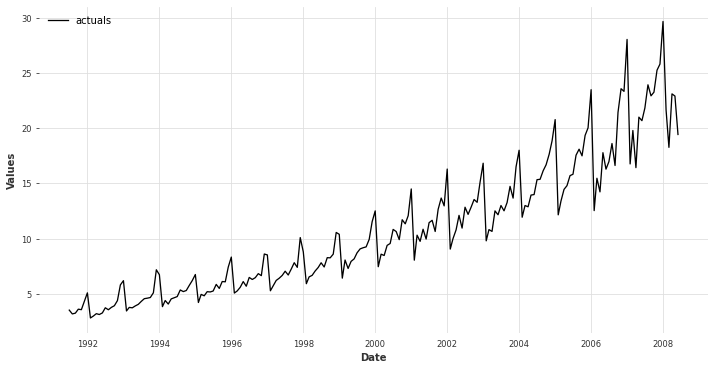

In [46]:
f.plot()

In [56]:
test = SeriesTransformer(f)

In [36]:
import math
def log10(x):
    return [math.log(i,base=10) for i in x]

In [49]:
f = test.LogTransform()

C:\Users\prateek.kumar\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\prateek.kumar\AppData\Local\Temp\ipykernel_20824\2332504511.py:43: RuntimeWarning: invalid value encountered in log
  self.f.levely = list(transform_func(self.f.levely, **kwargs))


<Axes: xlabel='Date', ylabel='Values'>

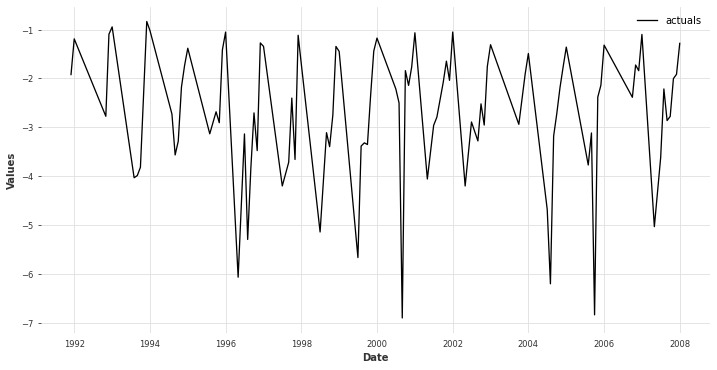

In [50]:
f.plot()

In [57]:
f = test.DetrendTransform()

<Axes: xlabel='Date', ylabel='Values'>

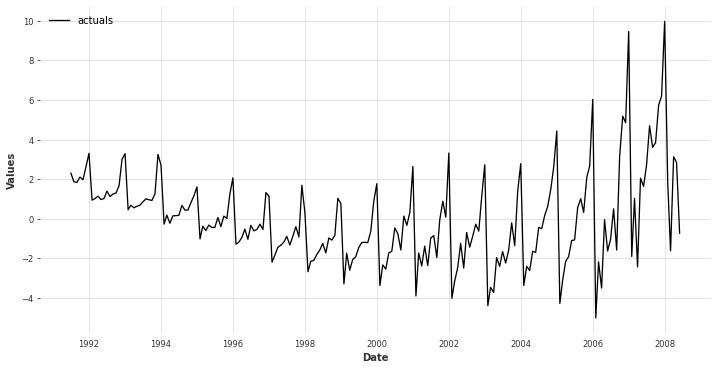

In [58]:
f.plot()

In [59]:
f = test.DetrendRevert()

<Axes: xlabel='Date', ylabel='Values'>

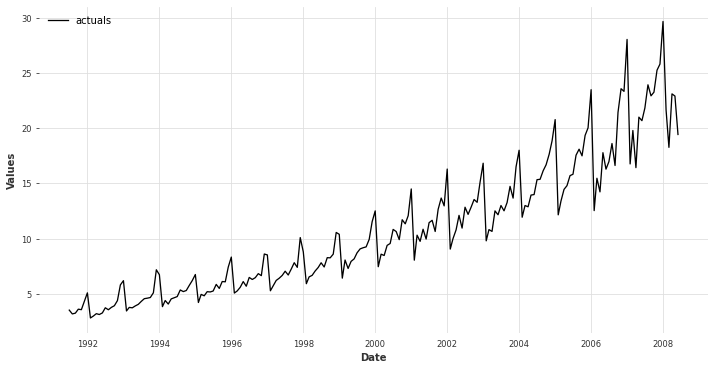

In [60]:
f.plot()

In [71]:
test.__repr__()

'SeriesTransformer(\nForecaster(\n    DateStartActuals=1991-07-01T00:00:00.000000000\n    DateEndActuals=2008-06-01T00:00:00.000000000\n    Freq=MS\n    N_actuals=204\n    ForecastLength=13\n    Xvars=[]\n    Differenced=0\n    TestLength=0\n    ValidationLength=1\n    ValidationMetric=rmse\n    ForecastsEvaluated=[]\n    CILevel=None\n    CurrentEstimator=mlr\n    GridsFile=Grids\n)\n)'

In [72]:
f = test.DeseasonTransform()

<Axes: xlabel='Date', ylabel='Values'>

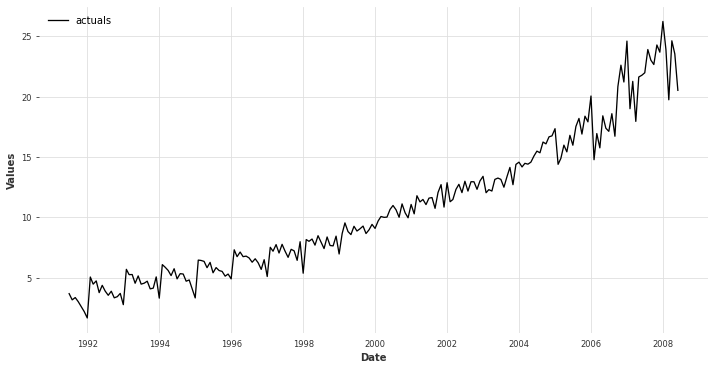

In [73]:
f.plot()

# Rough

### Fourier Trans on TS

In [68]:
import numpy as np

# Generate some example data
N = 100
t = np.linspace(0, 10, N)
y = np.sin(2*np.pi*1*t) + 0.5*np.sin(2*np.pi*2*t)

# Compute the Fourier Transform
y_fft = np.fft.fft(y)

In [69]:
y,y_fft

(array([ 0.00000000e+00,  1.07035905e+00,  1.23843217e+00,  6.35921326e-01,
         9.99859337e-02, -1.59736698e-05, -1.32253202e-01, -7.07003463e-01,
        -1.26753236e+00, -9.95456815e-01,  1.26720146e-01,  1.13519149e+00,
         1.20092483e+00,  5.66007208e-01,  7.29507098e-02, -4.30421124e-04,
        -1.69849768e-01, -7.78337179e-01, -1.28750678e+00, -9.11059451e-01,
         2.52166447e-01,  1.18951268e+00,  1.15581782e+00,  4.98112854e-01,
         5.09385457e-02, -1.98467312e-03, -2.12757108e-01, -8.48955163e-01,
        -1.29773829e+00, -8.17868144e-01,  3.75082472e-01,  1.23301910e+00,
         1.10399373e+00,  4.33012702e-01,  3.36346811e-02, -5.41307674e-03,
        -2.60838853e-01, -9.17854078e-01, -1.29772232e+00, -7.16701961e-01,
         4.94246355e-01,  1.26554769e+00,  1.04639536e+00,  3.71392708e-01,
         2.06263385e-02, -1.14121481e-02, -3.13840761e-01, -9.84010161e-01,
        -1.28707636e+00, -6.08487410e-01,  6.08487410e-01,  1.28707636e+00,
         9.8

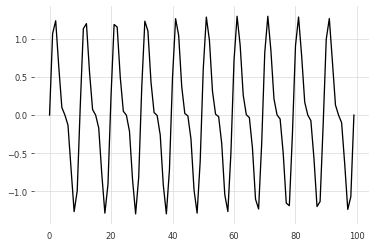

In [70]:
plt.plot(y)

C:\Users\prateek.kumar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


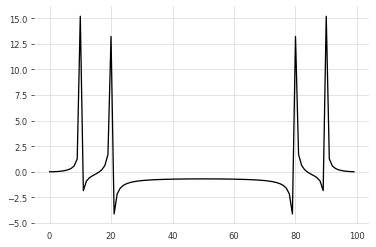

In [71]:
plt.plot(y_fft)

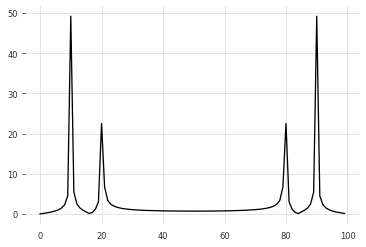

In [72]:
y_fft_mag = np.abs(y_fft)
plt.plot(y_fft_mag)

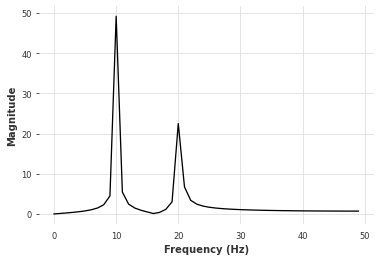

In [73]:
freqs = np.fft.fftfreq(N, 1/N)
freqs_pos = freqs[:N//2]
y_fft_mag_pos = y_fft_mag[:N//2]

import matplotlib.pyplot as plt
plt.plot(freqs_pos, y_fft_mag_pos)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

### Wavelets

In [114]:
'''
Wavelet transform is a mathematical tool that is used to decompose a time series signal into different frequency bands, 
with each band representing a different scale or frequency of the original signal. The wavelet transform is useful for 
capturing non-stationary and irregular patterns in the time series data.
'''

import pywt

def wavelet_transform(X):
    coeffs = pywt.wavedec(X, 'db4', mode='symmetric', level=3)
    return np.concatenate(coeffs)

X = np.random.rand(100)
wavelet_coeffs = wavelet_transform(X)

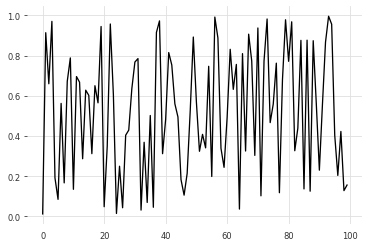

In [76]:
plt.plot(X)

In [78]:
wavelet_coeffs

array([ 1.48826183,  1.46613604,  1.59896502,  1.47904687,  1.54549315,
        1.28239146,  1.59651078,  1.2555641 ,  1.04347675,  1.65994962,
        1.19048986,  1.49653977,  1.62020932,  1.66594992,  1.8924772 ,
        1.58880932,  1.72448128,  0.07347469,  0.00441256,  0.04176646,
        0.2469581 ,  0.20138657, -0.04342981, -0.5987044 , -0.55158362,
        0.36688846,  0.28075788, -0.08249957,  0.02800745,  0.03673488,
        0.05342601, -0.14998699, -0.51328687,  0.15970574,  0.56284055,
       -0.10950183, -0.26992215, -0.86527909,  0.12442343,  0.22007519,
        0.05011742, -0.06647978, -0.17484306,  0.04283721,  0.0995261 ,
       -0.18989854, -0.17918603, -0.53089461,  0.09350446,  0.03309925,
       -0.44482944,  0.15301991, -0.50864516, -0.18848698,  0.28588275,
       -0.21530962,  0.01474242,  0.51189606, -0.12409869,  0.16067606,
       -0.07249351, -0.50468378,  0.07600729,  0.08316153,  0.49299701,
       -0.1698476 , -0.08897944, -0.33036689, -0.35197336,  0.47

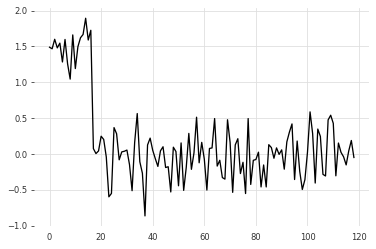

In [77]:
plt.plot(wavelet_coeffs)

### Entropy

In [113]:
'''
Entropy measures the amount of disorder or randomness in a time series. There are different types of entropy measures, 
such as Shannon entropy, approximate entropy, and sample entropy.
'''

from scipy.stats import entropy

def shannon_entropy(X):
    return entropy(X)

X = np.random.rand(100)
entropy_val = shannon_entropy(df.value)

In [85]:
entropy_val

5.170632532652698

In [88]:
base = 2  # work in units of bits
pk = np.array([1/2, 1/2])  # fair coin
H = entropy(pk, base=base)
print(H)
H == -np.sum(pk * np.log(pk)) / np.log(base)

1.0


True

In [89]:
qk = np.array([9/10, 1/10])  # biased coin
entropy(qk, base=base)

0.46899559358928117